# Notebook for measuring a resonator sample with the streamline NA line 2 to 4 (bottom resonator) "old VNA"

### IMPORTANT: the streamline software must be open on the PC (otherwise the connection to the streamline NA will not work), start it by clicking on the windows icon in the bottom left corner of the screen, scroll down to 'Keysight Network Analyzer' folder, expand it, click the green icon and start VNA with Chassis number 1, if you want parallel measurements with two VNAs, then repeat this step and open a second window for the other VNA 

## 0. Imports

In [1]:
#script for the second VNA that measures line 2 to 4 (bottom resonator)
import sys 
#set the path to where the folder Core is found
sys.path.insert(0, r"Z:\ZEITlab-Data\MOL\Kiutra_Cryostat\T_resonator_meas_streamline_NA") 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import os
import time
import pyvisa
import yaml
import pickle
from datetime import datetime, timedelta

import Core.Config_streamline as Conf
from Core.VNA import VNA
from Core.Measurement import Measurement
from Core.PNA import PNA
from Core.CircleFit import notch_port
import Core.Utility as Utility

from IPython.display import clear_output
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output

## 1. Device setup

#### a. Setup at the PXI Device
Start the device, make sure the USB connection is properly set up.

For resonator measurements: make sure that

-all lines are properly connected

-the power source of the HEMT is connected

-the RT amplifier is switched on

-the software 'Network Analyser' is open on the PC (for streamline network analyzers)

-in Keysight Connection Expert hislip is turned on for the PXI instrument (streamline network analyzer) so it can accept python commands

#### b. Setup with pyvisa
After running the cell below, the device communication should work properly.

In [2]:
vna = PNA(address=f'TCPIP0::TUEILAB-L00314B::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR')  # This visa address has this special form because it's a PXI (VNAs with IP-address)
vna_name = vna.query('*IDN?').strip()
print(f"Connected VNA: {vna_name}")  # check that connection is established
vna.write(f"SYSTem:FPReset") #presets the device
vna.set_rf_off()  # turn off rf output (so it doesn't raise the temp of MXC by sending signals continously)
vna.write("TRIG:SOUR MAN")  # set trigger source to manual

measurement_type = 'S21'

Meas_name = "Meas{}".format(1)  # name of the measurement, only important for device
vna.write(f"CALCulate{1}:PARameter:DEFine:EXT '{Meas_name}',{measurement_type}")  # create new measurement
vna.write(f"DISPlay:WINDow{1}:STATE ON")  # turn on or create corresponding window
vna.write(f"DISPlay:WINDow{1}:TRACe{1}:FEED '{Meas_name}'")  # feed the measurement to window and create trace 
vna.write(f"CALCulate{1}:PARameter:SELect '{Meas_name}',fast")  # select the fast measurement
vna.write("SENS1:SWE:MODE HOLD")  # set sweep mode to hold

Connected VNA: Keysight Technologies,P5002B,MY61100168,A.17.35.10


#### c. Troubleshooting
If the upper cell is not executable, the streamline NA might not be in the network. All available resources can be listed with the following cell.

In [3]:
print(pyvisa.ResourceManager().list_resources())

('PXI0::13-0.0::INSTR', 'PXI0::8-0.0::INSTR', 'TCPIP0::TUEILAB-L00314B::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR')


## 2. Measurement configuration

Make sure the Config file is accessible and that all the necessary data in it are updated

#### a. General (At start or after changing the config file, please run this cell)

In [4]:
vna = VNA(name='PNA', address=f'TCPIP0::TUEILAB-L00314B::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR')  # initiate the connection 
operator = Conf.get_operator()
print(f"operator: {operator}")
prefix = os.environ.get('MEASUREMENT_FILE_PREFIX', '')  # Prefix abrufen (falls nicht gesetzt, Standard ist leer)
chip = f"{prefix}_{Conf.get_chip()}" if prefix else Conf.get_chip()
print(f"chip: {chip}")
base_path= Conf.get_base_path()
print(f"base_path: {base_path}")
fwhm_span = Conf.get_fwhm_span()
print(f"fwhm span: {fwhm_span}")
att = Conf.get_attenuation()
print(f"attenuation: {att}")

operator: Moritz
chip: Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C
base_path: Z:\ZEITlab-Data\MOL\Kiutra_Cryostat\T_resonator_meas_streamline_NA
fwhm span: 9.0
attenuation: -90.0


#### b. Spectrum analysis (S)

In [5]:
f_start_S =3e9 #3e9
f_end_S = 9e9 #9e9
nop_S = 100001
bw_S = 1000 #1000
vna_power_S = -30
confidence_S = 5
skip_hz_S = 50e6  

#### c. Peak  Finding (F)

In [6]:
nop_F = 701
span_F = 1e6
vna_power_F = -30
bw_F = 200
fixed_delay_F = None

#### d. Power Sweep (P)

In [7]:
nop_P = 200  # number of points
nos_P = 11  # number of segments

# piecewise power sweep settings
power_low_P = -140
power_mid_P = -120
power_high_P = -90

power_step_low_P = 2  # step size between power_low_P and power_mid_P
power_step_high_P = 5  # step size between power_mid_P and power_high_P

# measurement order
power_sweep_resonator_first = True  # True: per resonator high->low, False: per power across all resonators

max_measurement_time_s = None  # e.g. 2 * 3600 for 2 hours
max_adjustment_iterations = 3
min_power_step_db = 0.25


def build_pow_bw_avg(power_low, power_mid, power_high, step_low, step_high):
    if not (power_low < power_mid < power_high):
        raise ValueError("Expected power_low < power_mid < power_high")
    if step_low <= 0 or step_high <= 0:
        raise ValueError("Power steps must be positive")

    upper = Utility.get_pow_bw_avg(power_mid, power_high, step_high)
    lower = Utility.get_pow_bw_avg(power_low, power_mid, step_low)

    if upper and lower and upper[-1][0] == lower[0][0]:
        lower = lower[1:]

    return upper + lower


#  3.Spectrum analysis

#### a. Measure data with NA

In [8]:
sub_folder = "spectrum"
base = f"{base_path}\\{chip}\\{sub_folder}"

if Path(base).exists():
    print(f"WARNING: Subfolder {base} does already exist! Plots will be overwritten.\n")
else:
    Path(base).mkdir(parents=True, exist_ok=True)

In [9]:
f_start = f_start_S
f_end = f_end_S
nop = nop_S
bw = bw_S
vna_power = vna_power_S
frequencies = np.linspace(f_start, f_end, nop)
measurement = Measurement( chip, bw, vna_power, frequencies, 1, sub_folder,measurement_type='S21')
measurement.set_comment(f"S21 @{vna_name} full spectrum measurement: {operator} {chip}")

vna.pna.set_power(vna_power)
vna.pna.set_bandwidth(bw)
vna.pna.set_lin_frequencies(f_start,f_end,nop)
vna.pna.set_averages(1)   #no averages are needed

sweep_time= float(vna.pna.query('SENS1:SWE:TIME?'))
print(f"measurement time: {sweep_time:.1f}s")

vna.rf_on()

try:
    old_timeout = vna.pna._visainstrument.timeout
    full_time = vna.pna.get_sweep_time()
    vna.pna._visainstrument.timeout = full_time*1000+500
    measurement.set_start_time()
    vna.pna.write('*CLS;INIT1:IMM;*OPC')
    while not (int(vna.pna.query('*ESR?')) & 1):
        time.sleep(0.002)    
    time.sleep(0.2)
    vna.pna.wait()
    incoming=vna.pna.query('CALC1:MEAS1:DATA:SDATA?')
    if type(incoming) is str:
        incoming = [float(i) for i in incoming.split(',')]
    incoming_size = np.size(incoming)
    incomingreal = np.array(incoming[0:incoming_size:2])
    incomingimag = np.array(incoming[1:incoming_size:2])
    s21= incomingreal + 1j * incomingimag
    measurement.set_data(s21)
    path=measurement.save(base_path=base_path)
    vna.pna._visainstrument.timeout=old_timeout
    print("...done")
finally:
    vna.rf_off()
    print('RF off.')

f = frequencies

measurement time: 96.1s
...done
RF off.


#### b. Absolute value $|S_{21}|$ and derivative $\frac{dS_{21}}{df}$

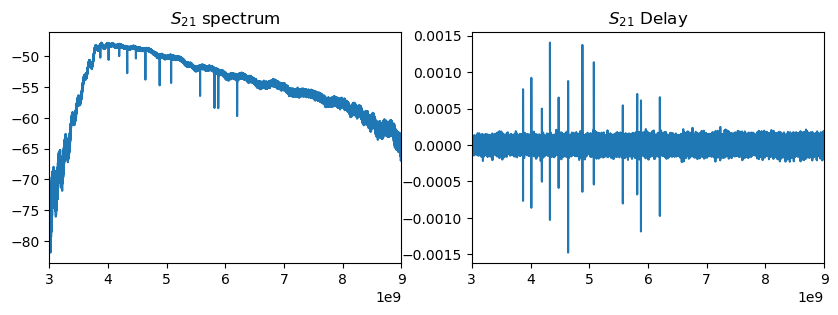

In [10]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 3, forward=True)

ax1 = ax[0]
ax2 = ax[1]

ax1.set_title("$S_{21}$ spectrum")
ax1.plot(f, 20*np.log10(np.abs(s21)))
ax1.set_xlim(f[0], f[-1])


s21_delay = np.append(np.diff(np.abs(s21)), [0])

ax2.set_title("$S_{21}$ Delay")
ax2.plot(f, s21_delay)
ax2.set_xlim(f[0], f[-1])

plt.show()

#### c. Calculate and plot peak positions

In [11]:
def peak_finding(chip, s_delay,f, confidence=20, skip_hz=50e6):    

    std = np.std(s_delay)

    found_peak_fr = []

    skip_nop = int(skip_hz/(f[1]-f[0]))  # assuming linspace for frequencies

    skips = 0

    for i in range(len(f)):
        if skips > 0:
            skips -= 11
            continue
        if abs(s_delay[i]) > confidence*std:
            found_peak_fr.append(int(f[i]))
            skips = skip_nop

    print(f"{chip}: Number of detected frequencies: {len(found_peak_fr)}")

    found_peak_inv = []
    skips = 0
    for i in range(len(f)):
        if skips > 0:
            skips -= 1
            continue
        if abs(s_delay[-(i+1)]) > confidence*std:
            found_peak_inv.append(int(f[-(i+1)]))
            skips = skip_nop

    found_peak_detailed = []

    if len(found_peak_fr) != len(found_peak_inv):
        print("forward and backward scan does not match. Using forward positions only.")
        found_peak_detailed = found_peak_fr
    else:
        for i in range(len(found_peak_fr)):
            found_peak_detailed.append(found_peak_fr[i]/2+found_peak_inv[-(i+1)]/2)
    return found_peak_fr, found_peak_inv, found_peak_detailed

In [12]:
confidence = confidence_S 
skip_hz = skip_hz_S
found_peak_fr, found_peak_inv, found_peak_detailed = peak_finding(chip,s21_delay,f, confidence=confidence,skip_hz=skip_hz)
print(f"rough_peaks_{chip} = {found_peak_detailed}")

Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C: Number of detected frequencies: 12
rough_peaks_Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C = [3872430000.0, 4013250000.0, 4193760000.0, 4330590000.0, 4478760000.0, 4640100000.0, 4882920000.0, 5078280000.0, 5571900000.0, 5816700000.0, 5881140000.0, 6202560000.0]


#### d. Plot found frequencies $S_{21}$

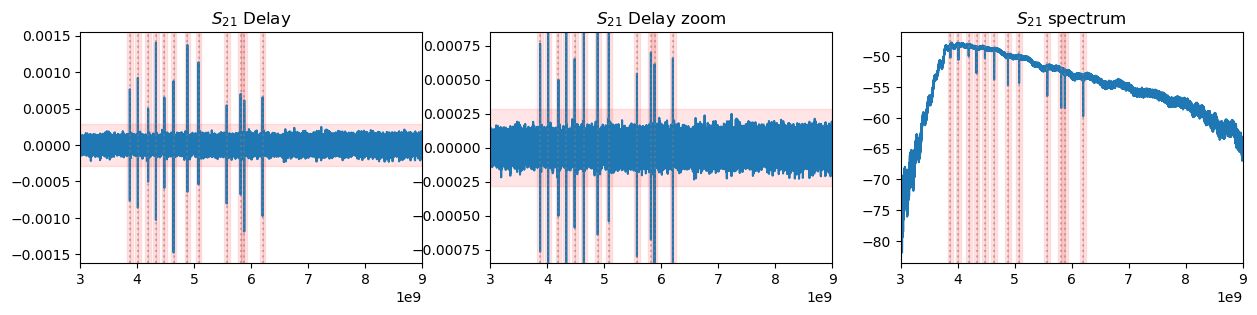

In [13]:
y_scale = 3
confidence = confidence_S 
skip_hz = skip_hz_S

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 3, forward=True) # 21, 4

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

std = np.std(s21_delay)

ax1.set_title("$S_{21}$ Delay")
ax1.set_xlim(f[0],f[-1])
ax1.plot(f, s21_delay)
ax1.axhspan(-confidence*std, confidence*std, alpha=0.1, color='red')
for fr in found_peak_fr:
    ax1.axvspan(fr, fr+skip_hz, alpha=0.1, color='red')
for fr in found_peak_inv:
    ax1.axvspan(fr, fr-skip_hz, alpha=0.1, color='red')
for fr in found_peak_detailed:
    ax1.axvline(fr, color='gray', alpha=0.5, ls=':')

ax2.set_title("$S_{21}$ Delay zoom")
ax2.set_xlim(f[0],f[-1])
ax2.plot(f, s21_delay)
ax2.axhspan(-confidence*std, confidence*std, alpha=0.1, color='red')
for fr in found_peak_fr:
    ax2.axvspan(fr, fr+skip_hz, alpha=0.1, color='red')
for fr in found_peak_inv:
    ax2.axvspan(fr, fr-skip_hz, alpha=0.1, color='red')
for fr in found_peak_detailed:
    ax2.axvline(fr, color='gray', alpha=0.5, ls=':')
ax2.set_ylim(-confidence*std*y_scale, confidence*std*y_scale)

ax3.set_title("$S_{21}$ spectrum")
ax3.set_xlim(f[0],f[-1])
ax3.plot(f, 20*np.log10(np.abs(s21)))
for fr in found_peak_fr:
    ax3.axvspan(fr, fr+skip_hz, alpha=0.1, color='red')
for fr in found_peak_inv:
    ax3.axvspan(fr, fr-skip_hz, alpha=0.1, color='red')
for fr in found_peak_detailed:
    ax3.axvline(fr, color='gray', alpha=0.5, ls=':')

fig.savefig(f"{base}\\found_resonances.pdf")
plt.show()

# 4. Fine_peaks_finder

In [14]:
rough_peaks=found_peak_detailed

In [15]:
sub_folder = "peakfinding"
base = f"{base_path}\\{chip}\\{sub_folder}"

if Path(base).exists():
    print(f"WARNING: Subfolder {base} does already exist! Plots will be overwritten.\n")
else:
    Path(base).mkdir(parents=True, exist_ok=True)

#### a. Measurement and fitting

f=6.20 GHz


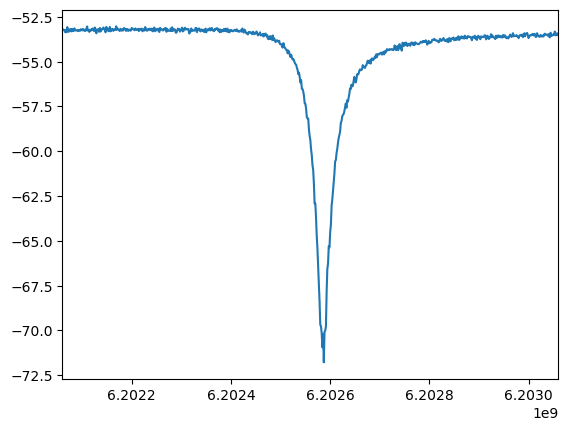

In [16]:
nop = nop_F
span = span_F
vna_power = vna_power_F
bw = bw_F
fixed_delay = fixed_delay_F


data = []

for f_peak in rough_peaks:
    frequencies = np.linspace(f_peak-span/2, f_peak+span/2, nop)
    measurement = Measurement(chip, bw, vna_power, frequencies, 1, sub_folder)
    measurement.set_comment(f"S21 @{vna_name} fine peak finding measurement: {chip} @ {f_peak/1e9:.3f} GHz")
    
    vna.pna.set_power(vna_power)
    vna.pna.set_bandwidth(bw)
    vna.pna.set_lin_frequencies(frequencies[0],frequencies[-1],nop)
    vna.pna.set_averages(1)
    
    vna.rf_on()
    try:
        old_timeout = vna.pna._visainstrument.timeout
        full_time = vna.pna.get_sweep_time()
        vna.pna._visainstrument.timeout = full_time*1000+500
        measurement.set_start_time()
        vna.pna.write('*CLS;INIT1:IMM;*OPC')
        while not (int(vna.pna.query('*ESR?')) & 1):
            time.sleep(0.002)    
        time.sleep(0.2)
        vna.pna.wait()
        incoming=vna.pna.query('CALC1:MEAS1:DATA:SDATA?')
        if type(incoming) is str:
            incoming = [float(i) for i in incoming.split(',')]
        incoming_size = np.size(incoming)
        incomingreal = np.array(incoming[0:incoming_size:2])
        incomingimag = np.array(incoming[1:incoming_size:2])
        s21= incomingreal + 1j * incomingimag
        measurement.set_data(s21)
        measurement.save(base_path=base_path)
        vna.pna._visainstrument.timeout=old_timeout
    finally:
        vna.rf_off()

    data.append((frequencies, s21))
    
    clear_output(wait=True)
    
    print(f"f={f_peak/1e9:.2f} GHz")
    plt.plot(frequencies, 20*np.log10(np.abs(s21)))
    plt.xlim(frequencies[0], frequencies[-1])
    plt.show()


In [17]:
fit_data = []

for f, s21 in data:
    
    fit = notch_port(f, s21)
    if fixed_delay is not None:
        fit.autofit(fixed_delay=fixed_delay)
    else:
        fit.autofit()

    fit_data.append((f, s21, fit.fitresults))

#### b.Plotting

In [18]:
num_plots = len(fit_data)

cols = 3 #4
rows = int(np.ceil(num_plots/cols))

#### i. plotting full response in frequency space

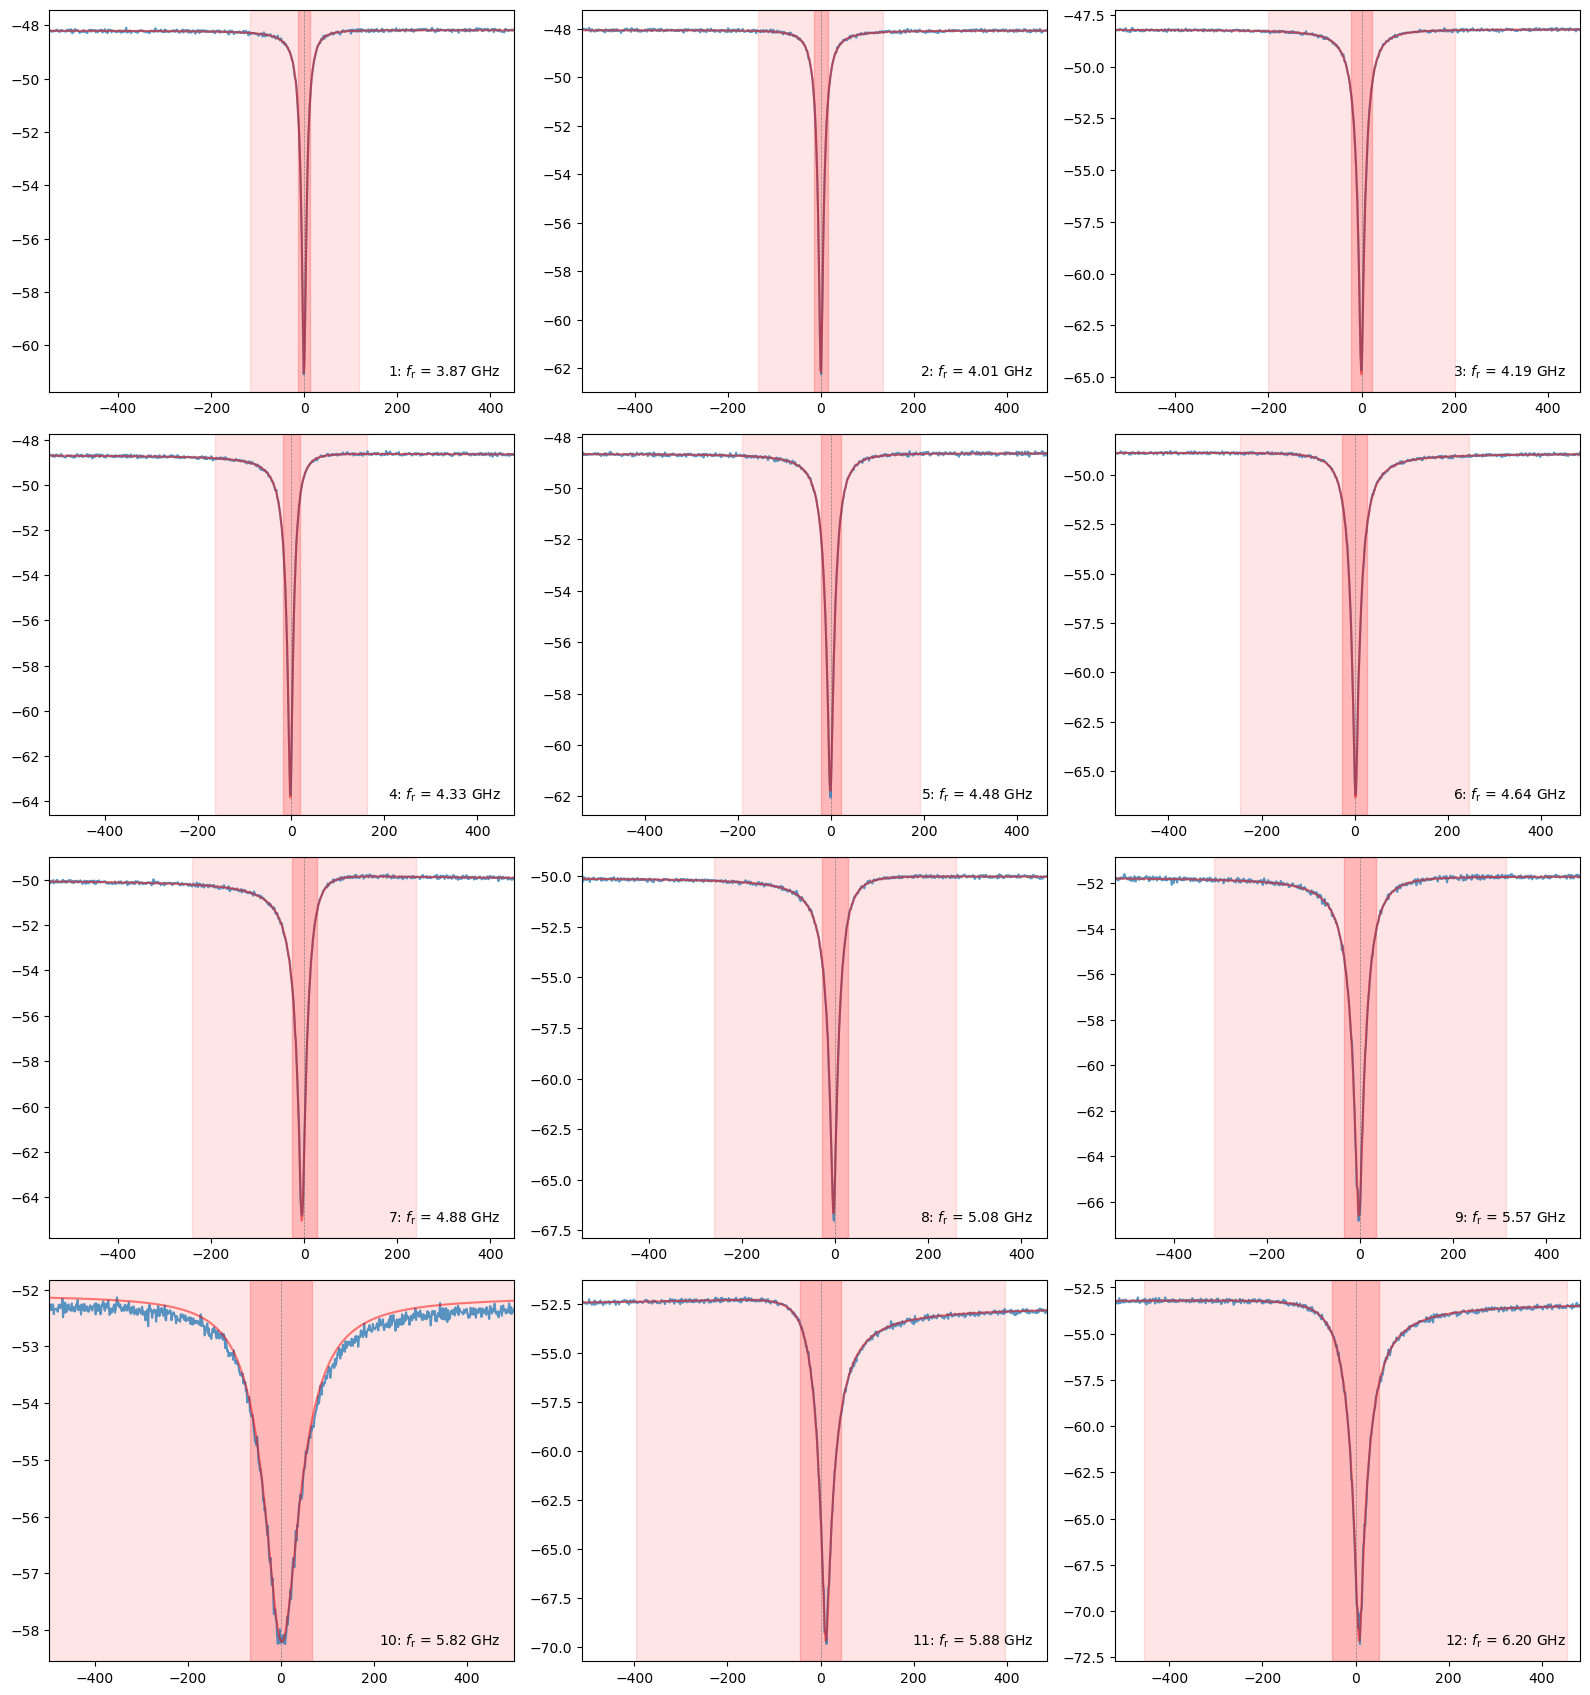

In [19]:
fig, ax = plt.subplots(nrows=rows, ncols=cols)
fig.set_size_inches(16, 16/cols*rows*0.8, forward=True)

i = -1

for f, s21, fit in fit_data:
  try:
    i += 1
    ax0 = ax[i // cols, i % cols]  # Access the subplot using row and column indices
    s21_fit = Utility.get_s21_response(np.array(f), fit)
    
    fr = fit["fr"]
    ql = fit["Ql"]
    
    ax0.axvline(0, c='gray', lw=0.5, ls='--')
    ax0.axvspan(-fr/ql/2000, fr/ql/2000, alpha=0.2, color='red')  # fwhm
    ax0.axvspan(-fr/ql*fwhm_span/2000, fr/ql*fwhm_span/2000, alpha=0.1, color='red')  # fit area
    ax0.plot((f-fr)/1000, 20*np.log10(np.abs(s21)), alpha=0.75)
    ax0.plot((f-fr)/1000, 20*np.log10(np.abs(s21_fit)), alpha=0.5, color='red')
    
    ax0.set_xlim((f[0]-fr)/1000, (f[-1]-fr)/1000)
    ax0.text(0.97, 0.03, str(i+1) + r': $f_\mathrm{r}$ = ' + f'{fr/1e9:.2f} GHz',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax0.transAxes,
        color='black', fontsize=10)
  except Exception as e:
        print(f"Error at index {i}: {e}")  # Print the error message and index

# Adjust layout
plt.tight_layout()

plt.show()


#### ii. plotting response around $Q_i$

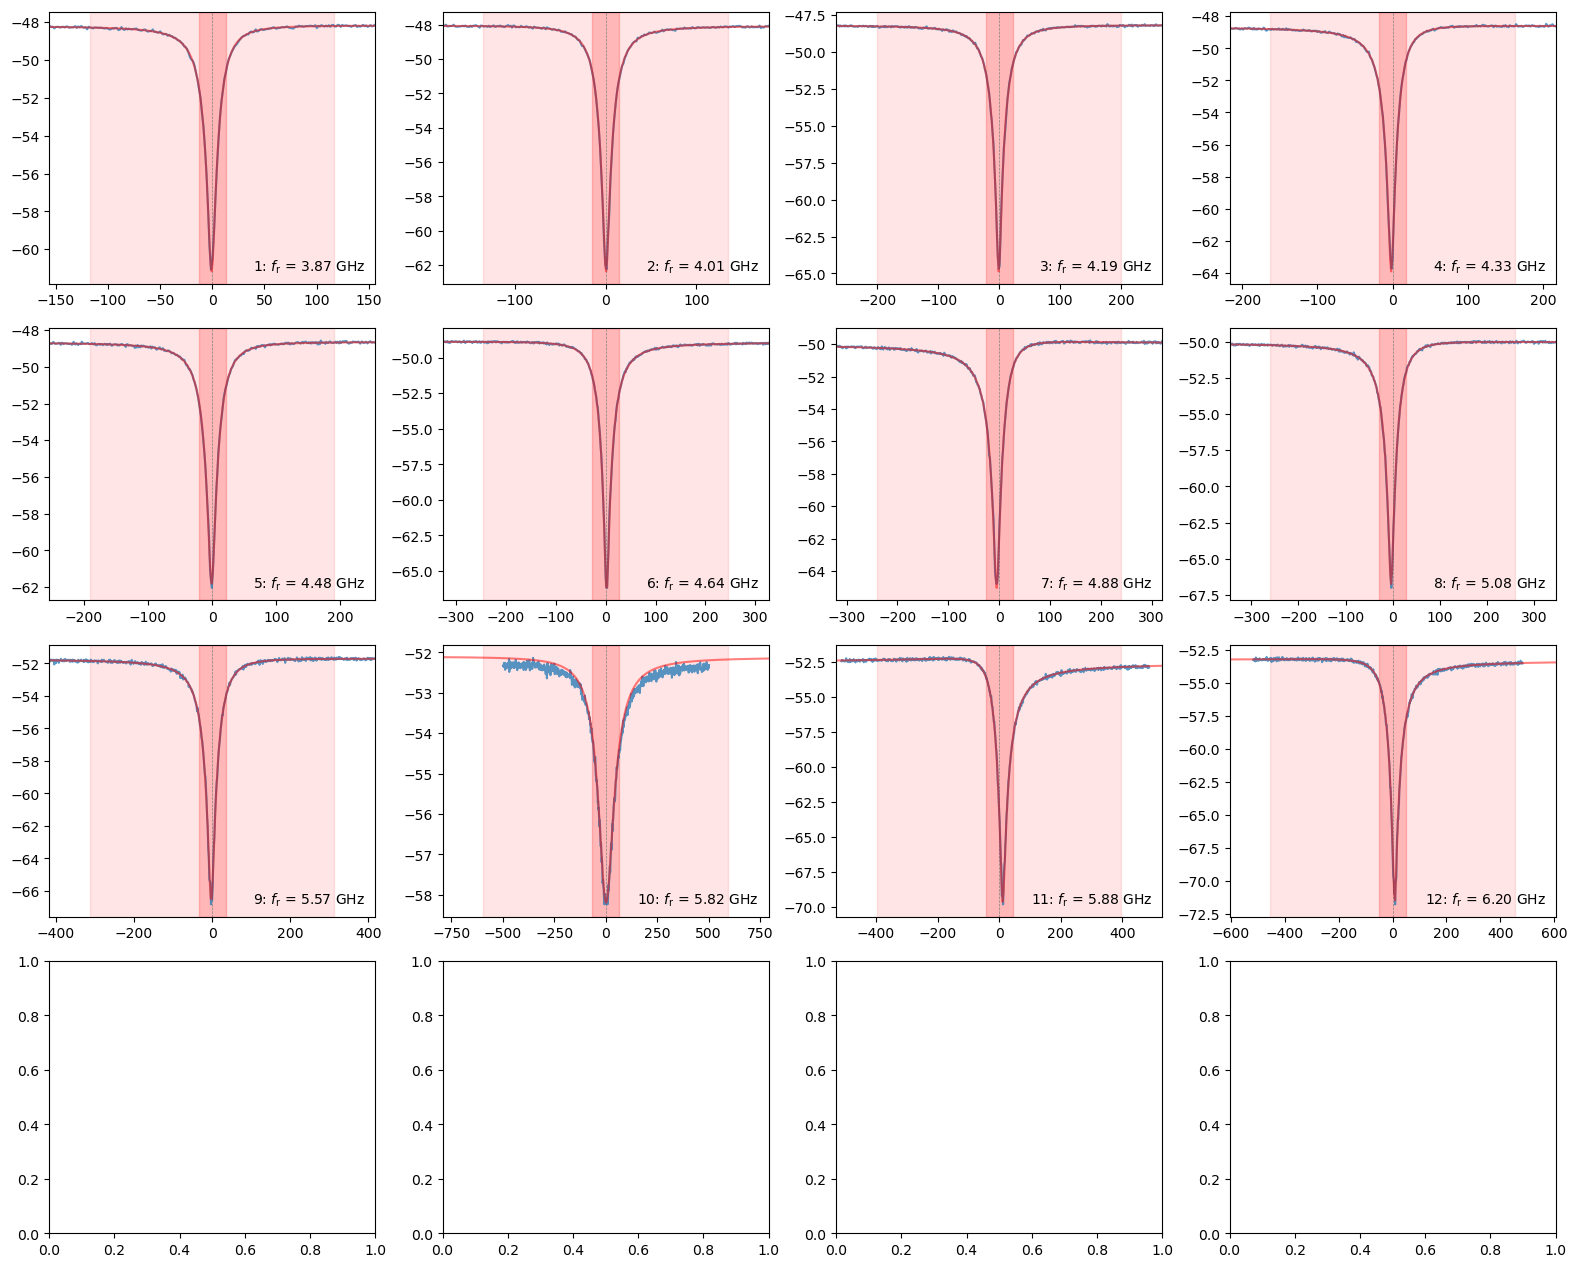

In [21]:
import numpy as np
import matplotlib.pyplot as plt

rows = 4  # Define the number of rows in the subplot grid
cols = 4  # Define the number of columns in the subplot grid

fig, ax = plt.subplots(nrows=rows, ncols=cols)
fig.set_size_inches(16, 16 / cols * rows * 0.8, forward=True)

i = -1

for f, s21, fit in fit_data:
    i += 1
    row = int(np.floor(i / cols))
    col = i % cols
    ax0 = ax[row, col]  # Access the subplot using row and col

    fr = fit["fr"]
    ql = fit["Ql"]

    f_fit = np.linspace(fr - fr / ql * fwhm_span, fr + fr / ql * fwhm_span, 500)
    s21_fit = Utility.get_s21_response(f_fit, fit)

    ax0.axvline(0, c='gray', lw=0.5, ls='--')
    ax0.axvspan(-fr / ql / 2000, fr / ql / 2000, alpha=0.2, color='red')  # fwhm
    ax0.axvspan(-fr / ql * fwhm_span / 2000, fr / ql * fwhm_span / 2000, alpha=0.1, color='red')  # fit area
    ax0.plot((f - fr) / 1000, 20 * np.log10(np.abs(s21)), alpha=0.75)
    ax0.plot((f_fit - fr) / 1000, 20 * np.log10(np.abs(s21_fit)), alpha=0.5, color='red')
    ax0.set_xlim(-fr / ql * fwhm_span / 1500, fr / ql * fwhm_span / 1500)
    ax0.text(0.97, 0.03, str(i + 1) + r': $f_\mathrm{r}$ = ' + f'{fr / 1e9:.2f} GHz',
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax0.transAxes,
             color='black', fontsize=10)

# Adjust layout
plt.tight_layout()

plt.show()


#### iii. plotting full response in complex space

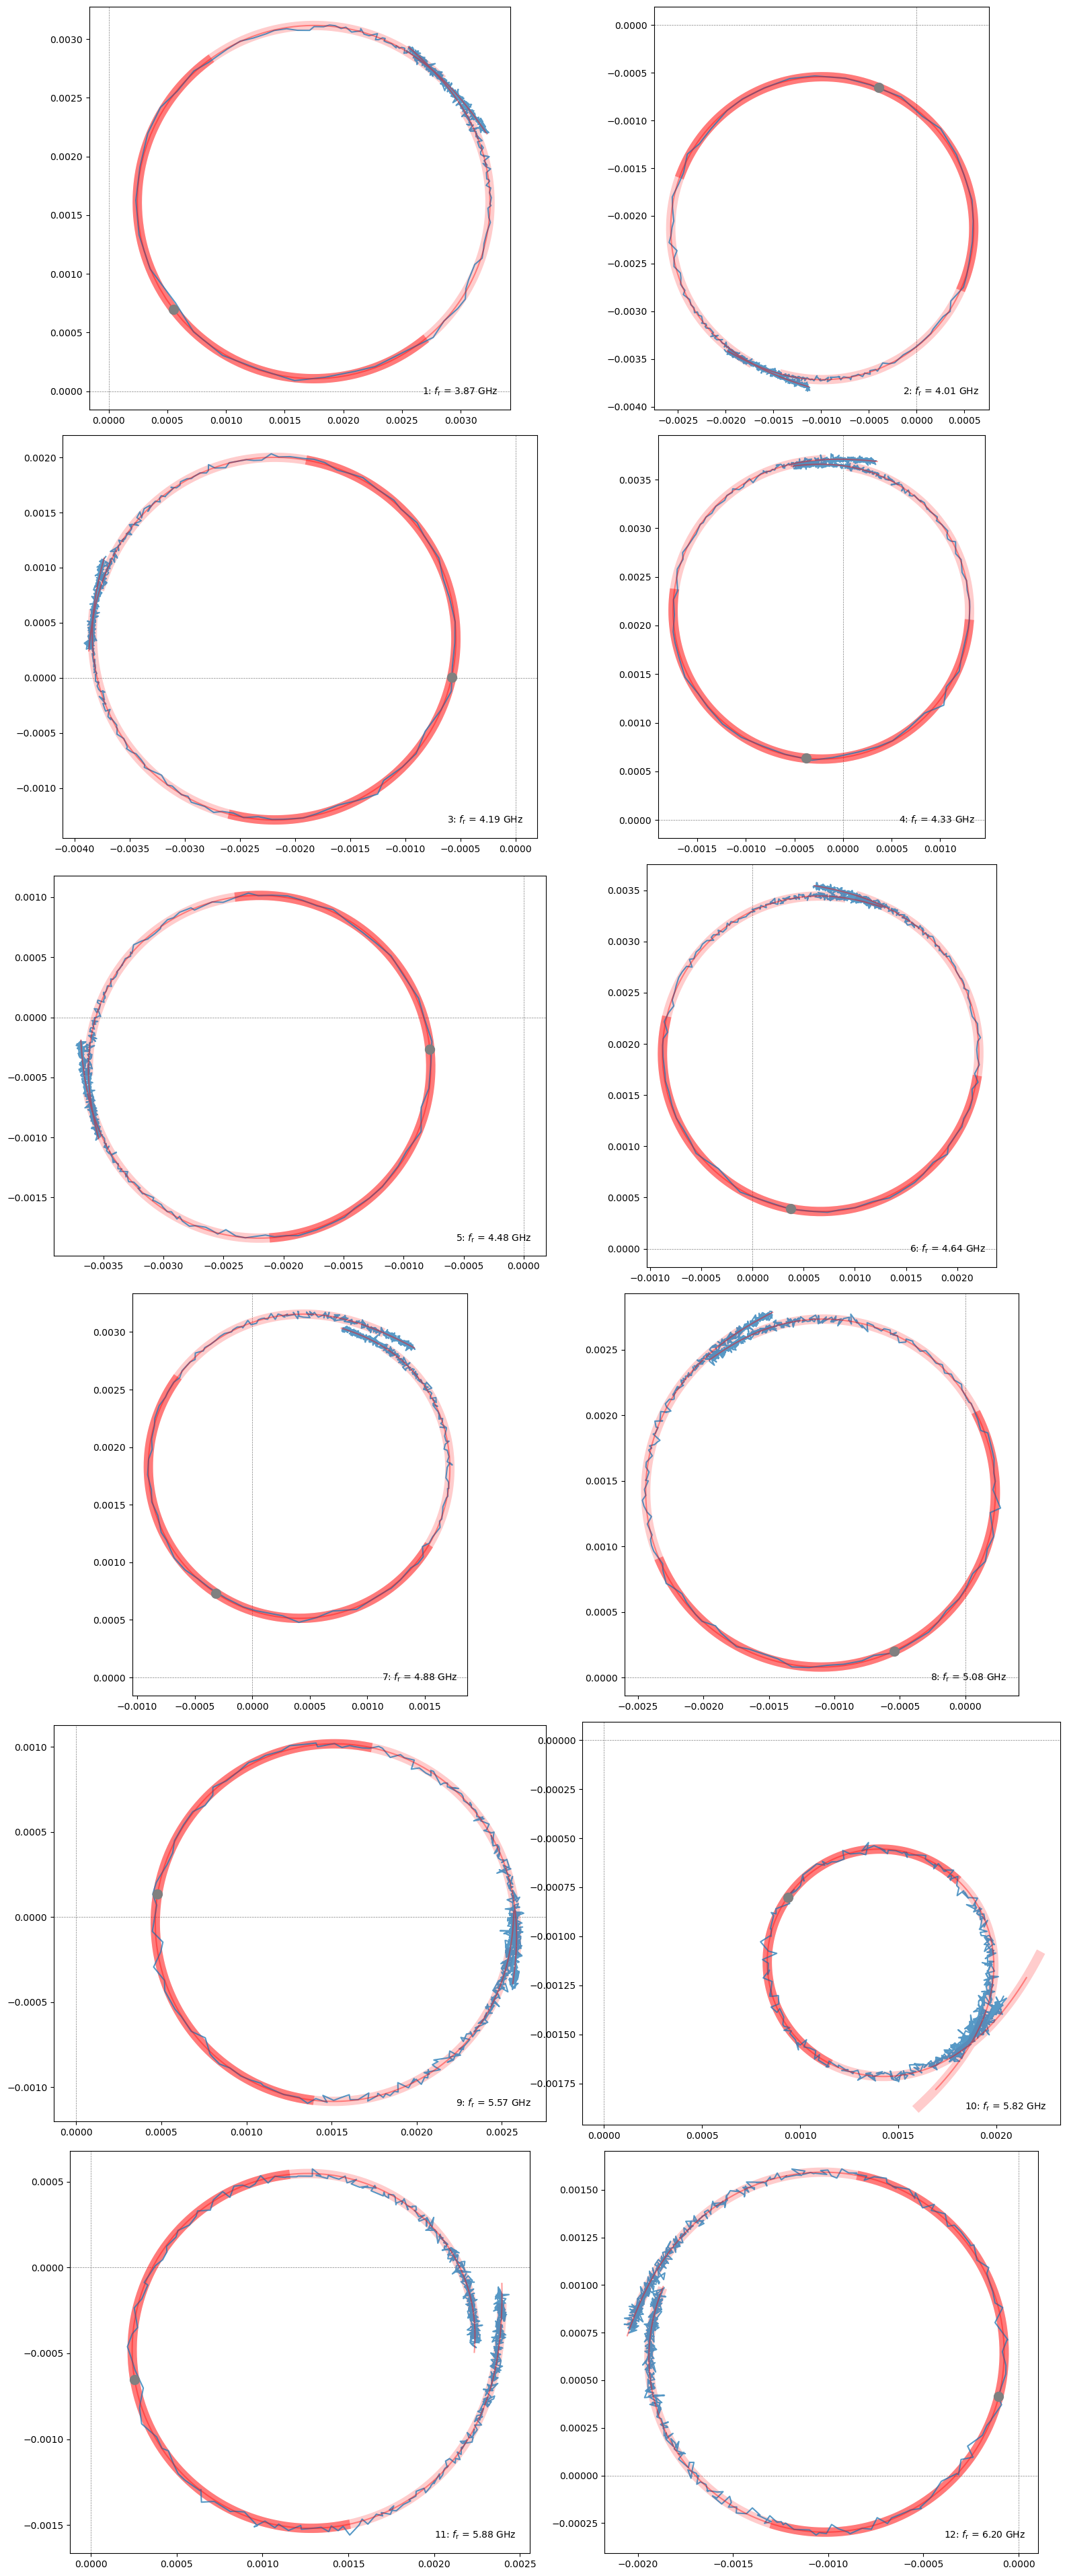

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the number of resonators
num_resonators = len(found_peak_fr)

# Determine the number of rows and columns based on the number of resonators
cols = 2 #4  # Set the number of columns per row
rows = (num_resonators + cols - 1) // cols  # Calculate the number of rows needed

# Create subplots
fig, ax = plt.subplots(nrows=rows, ncols=cols)
fig.set_size_inches(16, 16 / cols * rows * 0.8, forward=True)

i = -1

for f, s21, fit in fit_data:
    i += 1
    row = int(np.floor(i / cols))
    col = i % cols
    ax0 = ax[row, col]  # Access the subplot using row and col
    fr = fit["fr"]
    ql = fit["Ql"]

    res_point = Utility.get_s21_response(fr, fit)

    f_ql = np.linspace(fr - fr / ql / 2, fr + fr / ql / 2, 200)
    s21_ql = Utility.get_s21_response(f_ql, fit)

    f_interval_ql = np.linspace(fr - fr / ql / 2 * fwhm_span, fr + fr / ql / 2 * fwhm_span, 1000)
    s21_interval_ql = Utility.get_s21_response(f_interval_ql, fit)

    ax0.axhline(0, lw=0.5, ls='--', c='gray')
    ax0.axvline(0, lw=0.5, ls='--', c='gray')

    ax0.plot(np.real(s21_ql), np.imag(s21_ql), color='red', alpha=0.4, lw=10)
    ax0.plot(np.real(s21_interval_ql), np.imag(s21_interval_ql), color='red', alpha=0.2, lw=10)
    s21_fit = Utility.get_s21_response(np.linspace(f[0], f[-1], 2000), fit)
    ax0.plot(np.real(s21), np.imag(s21), alpha=0.75)
    ax0.plot(np.real(s21_fit), np.imag(s21_fit), '-', color="red", alpha=0.4)
    ax0.plot(np.real(res_point), np.imag(res_point), 'o', color='gray', markersize=10)
    ax0.axis('scaled')

    ax0.text(0.97, 0.03, str(i + 1) + r': $f_\mathrm{r}$ = ' + f'{fr / 1e9:.2f} GHz',
             verticalalignment='bottom', horizontalalignment='right',
             transform=ax0.transAxes,
             color='black', fontsize=10)

# Remove any empty subplots
for i in range(num_resonators, rows * cols):
    ax0 = ax[i // cols, i % cols]  # Access the subplot using row and col
    ax0.remove()

# Adjust layout
plt.tight_layout()

plt.show()


#### c. Fine peaks (no need to copy afterwards) 


In [23]:
f_res_q_l = []

for f, s21, fitresults in fit_data:
    f_res_q_l.append((int(fitresults["fr"]), int(fitresults["Ql"])))

print(f"fine_peaks_{chip} = {f_res_q_l}")

fine_peaks_Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C = [(3872478295, 148776), (4013263216, 133965), (4193790657, 93889), (4330610067, 119866), (4478794777, 105619), (4640115749, 85116), (4882968053, 91345), (5078324038, 87942), (5571927271, 80035), (5816698051, 44061), (5881152806, 66581), (6202577730, 61473)]


# 4. Power sweep

#### a. Device re-Setup

In [24]:
vna = PNA(address=f'TCPIP0::TUEILAB-L00314B::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR') 

print(f"Connected VNA: {vna.query('*IDN?')}")  # check that connection is established
vna.write(f"SYSTem:FPReset")
vna.set_rf_off()  # turn off output
vna.write("TRIG:SOUR MAN")  # set trigger source to manual

measurement_type ='S21'
Meas_name = "Meas{}".format(1)  # name of the measurement, only important for VNA
vna.write(f"CALCulate{1}:PARameter:DEFine:EXT '{Meas_name}',{measurement_type}")  # create new measurement
vna.write(f"DISPlay:WINDow{1}:STATE ON")  # turn on or create corresponding window
vna.write(f"DISPlay:WINDow{1}:TRACe{1}:FEED '{Meas_name}'")  # feed the measurement to window and create trace 
vna.write(f"CALCulate{1}:PARameter:SELect '{Meas_name}',fast")  # select the fast measurement 

vna.write("SENS1:SWE:MODE HOLD")  # set sweep mode to hold

Connected VNA: Keysight Technologies,P5002B,MY61100168,A.17.35.10



#### b. Preperation for measurement and measurement time estimation

In [25]:
fine_peaks = f_res_q_l

sub_folder = "full power sweep"

nop = nop_P # number of points
nos = nos_P  # number of segments
resonances=range(1, len(fine_peaks) + 1)

power_step_low_current = power_step_low_P
power_step_high_current = power_step_high_P
pow_bw_avg = build_pow_bw_avg(
    power_low_P,
    power_mid_P,
    power_high_P,
    power_step_low_current,
    power_step_high_current,
)

vna = VNA(sweep_mode="SEGMent", address=f'TCPIP0::TUEILAB-L00314B::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR')


In [26]:
print(pow_bw_avg)

[(-90, 98, 1), (-95, 72, 1), (-100, 52, 1), (-105, 37, 1), (-110, 26, 1), (-115, 17, 1), (-120, 10, 1), (-125, 5, 1), (-130, 2, 1), (-135, 1, 1), (-140, 1, 3), (-145, 1, 4), (-150, 1, 7), (-155, 1, 9), (-160, 1, 13)]


In [27]:
attenuation = att
print(f"Port1,2 @{vna_name}: {chip}")
print(f"Attenuation: {attenuation} dB")
if attenuation> 0:
    print(f"WARNING: attenuation > 0! Is this intended?\n")
base = f"{base_path}\{chip}\{sub_folder}"
if Path(base).exists():
    print(f"WARNING: Subfolder {base} does already exist! Plots will be overwritten.\n")
else:
    Path(base).mkdir(parents=True, exist_ok=True)
print(f"Resonances: {np.array(resonances)}")
print(f"power steps (low/high): {power_step_low_current} dB / {power_step_high_current} dB")
print(f"Max measurement time: {max_measurement_time_s} s")
print(f"power, bw, avg: {pow_bw_avg}\n\n")


Port1,2 @Keysight Technologies,P5002B,MY61100168,A.17.35.10: Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C
Attenuation: -90.0 dB
Resonances: [ 1  2  3  4  5  6  7  8  9 10 11 12]
power, bw, avg: [(-90, 98, 1), (-95, 72, 1), (-100, 52, 1), (-105, 37, 1), (-110, 26, 1), (-115, 17, 1), (-120, 10, 1), (-125, 5, 1), (-130, 2, 1), (-135, 1, 1), (-140, 1, 3), (-145, 1, 4), (-150, 1, 7), (-155, 1, 9), (-160, 1, 13)]




In [28]:
print(f"Port1,2 @{vna_name}: {chip}")

adjustment_iteration = 0
while True:
    f = IntProgress(min=0, max=len(resonances)*len(pow_bw_avg), description='Estimating: ')
    display(f)

    total_time = 0
    try:
        vna.pna._ci=1
        if power_sweep_resonator_first:
            for resonance in resonances:
                fr, ql = fine_peaks[resonance-1]
                for power, bw, avg in pow_bw_avg:
                    vna_power = power - attenuation

                    segment_list, frequencies = Utility.get_binned_frequencies(fr, ql, fwhm_span, nop, nos)
                    measurement = Measurement(chip, bw, vna_power, frequencies, avg, num_segments=nos, segment_list=segment_list)
                    vna.set_measurement(measurement)
                    total_time += float(vna.pna.query('SENS1:SWE:TIME?'))*avg
                    f.value += 1
        else:
            for power, bw, avg in pow_bw_avg:
                vna_power = power - attenuation
                for resonance in resonances:
                    fr, ql = fine_peaks[resonance-1]

                    segment_list, frequencies = Utility.get_binned_frequencies(fr, ql, fwhm_span, nop, nos)
                    measurement = Measurement(chip, bw, vna_power, frequencies, avg, num_segments=nos, segment_list=segment_list)
                    vna.set_measurement(measurement)
                    total_time += float(vna.pna.query('SENS1:SWE:TIME?'))*avg
                    f.value += 1
    finally:
        vna.rf_off()  # not needed, but safe mechanism
        start_time = datetime.today()
        print(f"Start time: {start_time.strftime('%H:%M:%S, %a %d.%m.')}")
        d = start_time + timedelta(seconds=total_time)
        print(f"Finish time: {d.strftime('%H:%M:%S, %a %d.%m.')}")
        print(f"Total measurement time: {timedelta(seconds=total_time)}".split('.')[0])

    if max_measurement_time_s is None:
        break
    if total_time <= max_measurement_time_s:
        print(f"Estimated time is within limit ({total_time:.0f}s <= {max_measurement_time_s:.0f}s).")
        break

    adjustment_iteration += 1
    if adjustment_iteration > max_adjustment_iterations:
        print("Max adjustment iterations reached; keeping current power steps.")
        break

    scale = total_time / max_measurement_time_s
    power_step_low_current = max(min_power_step_db, power_step_low_current * scale)
    power_step_high_current = max(min_power_step_db, power_step_high_current * scale)
    pow_bw_avg = build_pow_bw_avg(
        power_low_P,
        power_mid_P,
        power_high_P,
        power_step_low_current,
        power_step_high_current,
    )

    print(
        f"Adjusting power steps by x{scale:.2f} to meet max time. "
        f"New steps (low/high): {power_step_low_current:.2f} / {power_step_high_current:.2f} dB"
    )


Port1,2 @Keysight Technologies,P5002B,MY61100168,A.17.35.10: Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C


IntProgress(value=0, description='Estimating: ', max=180)

Start time: 16:57:27, Mon 19.01.
Finish time: 17:08:11, Tue 20.01.
Total measurement time: 1 day, 0:10:43


In [29]:
# save basic experimental setup data in yaml file
yaml_data = {}
yaml_data["device"] = vna.query_command('*IDN?')
yaml_data["operator"] = operator
yaml_data["chip"] = chip
yaml_data["attenuation"] = attenuation
yaml_data["fwhm_span"] = fwhm_span
yaml_data["pow_bw_avg"] = pow_bw_avg
yaml_data["measurement_time"] = start_time.strftime('%Y-%m-%d %H:%M:%S')

with open(f"{base}\\experimental_data.yaml", 'w+') as yaml_file:
    yaml.dump(yaml_data, yaml_file, default_flow_style=False)
    print(f"Saved experimental data in {base}\\experimental_data.yaml")

Saved experimental data in Z:\ZEITlab-Data\MOL\Kiutra_Cryostat\T_resonator_meas_streamline_NA\Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C\full power sweep\experimental_data.yaml


#### c. Measurement

IntProgress(value=10, description='Progress: ', max=180)

Resonance 1 @ -135 dBm:


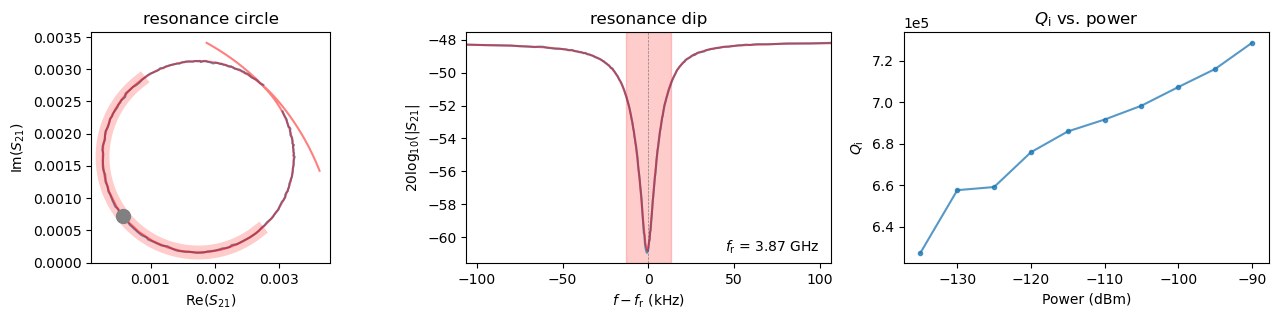

Measuring resonance res1 of Schoof_SF5_20min_2-2ubar_25Ar_1N2_550C (Port 1,2 @Keysight Technologies,P5002B,MY61100168,A.17.35.10) at -140 dBm from 17:03:56 until 17:13:29...


In [ ]:
progress = IntProgress(min=0, max=len(resonances)*len(pow_bw_avg), description='Progress: ') # instantiate the bar
data = {}
start_time = datetime.today()
vna.rf_on()  # set measurement should be safe due to calculated measurement time

try:
    if power_sweep_resonator_first:
        for resonance in resonances:
            # define one frequency span for all resonances - needs to be rewritten for resonances close to critical coupling
            fr, ql = fine_peaks[resonance-1]

            pow_dict = {}  # {power: (f, s21, fitresults)}

            for power, bw, avg in pow_bw_avg:

                try:
                    vna_power = power-attenuation

                    segment_list, frequencies = Utility.get_binned_frequencies(fr, ql, fwhm_span, nop, nos)
                    measurement = Measurement(chip, bw, vna_power, frequencies, avg, sub_folder + f"\Res{resonance}", num_segments=nos, segment_list=segment_list)
                    measurement.set_comment(f"Power sweep {chip} (Port 1,2 @{vna_name}): res{resonance} @ {power} dBm @ {fr/1e9:.3f} GHz")
                    vna.set_measurement(measurement)
                    now = datetime.today()
                    meas_time = vna.get_measurement_time()
                    print(f"Measuring resonance res{resonance} of {chip} (Port 1,2 @{vna_name}) at {power} dBm from {now.strftime('%H:%M:%S')} until {(now + timedelta(seconds=meas_time)).strftime('%H:%M:%S')}...")
                    old_timeout = vna.pna._visainstrument.timeout
                    vna.pna._visainstrument.timeout = meas_time*1000+500
                    measurement.set_start_time()
                    for i in range(avg):
                        vna.pna.write('*CLS;INIT1:IMM;*OPC')
                        while not (int(vna.pna.query('*ESR?')) & 1):
                            time.sleep(0.002)   
                    time.sleep(0.2)
                    vna.pna.wait()
                    incoming=vna.pna.query('CALC1:MEAS1:DATA:SDATA?')
                    if type(incoming) is str:
                        incoming = [float(i) for i in incoming.split(',')]
                    incoming_size = np.size(incoming)
                    incomingreal = np.array(incoming[0:incoming_size:2])
                    incomingimag = np.array(incoming[1:incoming_size:2])
                    s21= incomingreal + 1j * incomingimag
                    measurement.set_data(s21)
                    path= measurement.save(base_path=base_path)
                    vna.pna._visainstrument.timeout=old_timeout
                    f = measurement.get_frequencies()

                    fit = notch_port(f, s21)
                    fit.autofit()
                    fit.save_fitresults(path)
                    print(path)
                    fit.plotall(f"{base_path}\{chip}\{sub_folder}\Res{resonance}\{power}_{avg}avg.pdf")

                    pow_dict[power] = (f, s21, fit.fitresults)

                    ##### small visual report

                    fig, ax = plt.subplots(nrows=1, ncols=3)
                    fig.set_size_inches(16, 3, forward=True)

                    ax1 = ax[0]
                    ax2 = ax[1]
                    ax3 = ax[2]

                    mul = 10  # larger fit span
                    f_fit = np.linspace(fr-fr/ql/2*fwhm_span*mul, fr+fr/ql/2*fwhm_span*mul, nop*mul)
                    s21_fit = Utility.get_s21_response(f_fit, fit.fitresults)
                    fr_old = fr
                    ql_old = ql
                    fr = fit.fitresults["fr"]
                    ql = fit.fitresults["Ql"]

                    ax1.set_title("resonance circle")
                    ax1.plot(np.real(s21), np.imag(s21), alpha=0.75)
                    ax1.plot(np.real(s21_fit), np.imag(s21_fit), c='red', alpha=0.5)
                    f_interval_ql = np.linspace(fr-fr/ql/2, fr+fr/ql/2, 1000)
                    s21_interval_ql = Utility.get_s21_response(f_interval_ql, fit.fitresults)
                    ax1.plot(np.real(s21_interval_ql), np.imag(s21_interval_ql), color='red', alpha=0.2, lw=10)
                    res_point = Utility.get_s21_response(fr, fit.fitresults)
                    ax1.plot(np.real(res_point), np.imag(res_point), 'o', color='gray', markersize=10)
                    ax1.axis('scaled')
                    ax1.set_xlabel('Re($S_{21})$')
                    ax1.set_ylabel('Im($S_{21})$')

                    ax2.set_title("resonance dip")
                    ax2.axvline(0, c='gray', lw=0.5, ls='--')  # resonance
                    ax2.axvspan(-fr/ql/2000, fr/ql/2000, alpha=0.2, color='red')  # fwhm
                    ax2.plot((f-fr)/1000, 20*np.log10(np.abs(s21)), alpha=0.75)
                    ax2.plot((f_fit-fr)/1000, 20*np.log10(np.abs(s21_fit)), c='red', alpha=0.5)
                    ax2.set_xlabel('$f-f_\mathrm{r}$ (kHz)')
                    ax2.set_ylabel('$20\mathrm{log}_{10}(|S_{21}|$')
                    ax2.set_xlim((f[0]-fr)/1000, (f[-1]-fr)/1000)
                    ax2.text(0.97, 0.03, r'$f_\mathrm{r}$ = ' + f'{fr/1e9:.2f} GHz',
                        verticalalignment='bottom', horizontalalignment='right',
                        transform=ax2.transAxes,
                        color='black', fontsize=10)

                    ax3.set_title(r"$Q_\mathrm{i}$ vs. power")
                    pow, qi = Utility.get_Qi(pow_dict)
                    ax3.plot(pow, qi, '.-', alpha=0.75)
                    ax3.set_xlabel("Power (dBm)")
                    ax3.set_ylabel(r"$Q_\mathrm{i}$")
                    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                    for k, v in data.items():
                        pow, qi = Utility.get_Qi(v)
                        ax3.plot(pow, qi, '-', c='gray', lw=0.3, alpha=0.5)

                    clear_output(wait=True)
                    progress.value += 1
                    display(progress)
                    print(f"Resonance {resonance} @ {power} dBm:")
                    plt.show()

                    # reset ql and fr if it deviates too much
                    if ql < 0 or ql > 3*ql_old or ql < 0.3*ql_old:
                        print("Strong deviation in Ql detected. Continuing with old frequency range.")
                        ql = ql_old
                        fr = fr_old
                    if fr < 0 or abs(fr_old-fr) > 100e6:
                        print("Strong deviation in fr detected. Continuing with old frequency range.")
                        ql = ql_old
                        fr = fr_old
                except KeyboardInterrupt:
                    print(f'INTERRUPTED: Measurement of resonance res{resonance} of {chip} at {power}dBm interrupted!')
                    raise KeyboardInterrupt
                except Exception as e:
                    print(f'FAILED: Measurement of resonance res{resonance} of {chip} at {power}dBm failed!')
                    print(e)
            data[resonance] = pow_dict

            pickle_path = f"{base_path}\{chip}\{sub_folder}\measurement_data.pkl"
            with open(pickle_path, 'wb') as outp:  # Always overwrites the old existing file
                pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)
                print(f"Saved pickle measurement in {pickle_path}")
    else:
        for power, bw, avg in pow_bw_avg:
            vna_power = power-attenuation
            for resonance in resonances:
                # define one frequency span for all resonances - needs to be rewritten for resonances close to critical coupling
                fr, ql = fine_peaks[resonance-1]

                pow_dict = data.get(resonance, {})

                try:
                    segment_list, frequencies = Utility.get_binned_frequencies(fr, ql, fwhm_span, nop, nos)
                    measurement = Measurement(chip, bw, vna_power, frequencies, avg, sub_folder + f"\Res{resonance}", num_segments=nos, segment_list=segment_list)
                    measurement.set_comment(f"Power sweep {chip} (Port 1,2 @{vna_name}): res{resonance} @ {power} dBm @ {fr/1e9:.3f} GHz")
                    vna.set_measurement(measurement)
                    now = datetime.today()
                    meas_time = vna.get_measurement_time()
                    print(f"Measuring resonance res{resonance} of {chip} (Port 1,2 @{vna_name}) at {power} dBm from {now.strftime('%H:%M:%S')} until {(now + timedelta(seconds=meas_time)).strftime('%H:%M:%S')}...")
                    old_timeout = vna.pna._visainstrument.timeout
                    vna.pna._visainstrument.timeout = meas_time*1000+500
                    measurement.set_start_time()
                    for i in range(avg):
                        vna.pna.write('*CLS;INIT1:IMM;*OPC')
                        while not (int(vna.pna.query('*ESR?')) & 1):
                            time.sleep(0.002)   
                    time.sleep(0.2)
                    vna.pna.wait()
                    incoming=vna.pna.query('CALC1:MEAS1:DATA:SDATA?')
                    if type(incoming) is str:
                        incoming = [float(i) for i in incoming.split(',')]
                    incoming_size = np.size(incoming)
                    incomingreal = np.array(incoming[0:incoming_size:2])
                    incomingimag = np.array(incoming[1:incoming_size:2])
                    s21= incomingreal + 1j * incomingimag
                    measurement.set_data(s21)
                    path= measurement.save(base_path=base_path)
                    vna.pna._visainstrument.timeout=old_timeout
                    f = measurement.get_frequencies()

                    fit = notch_port(f, s21)
                    fit.autofit()
                    fit.save_fitresults(path)
                    print(path)
                    fit.plotall(f"{base_path}\{chip}\{sub_folder}\Res{resonance}\{power}_{avg}avg.pdf")

                    pow_dict[power] = (f, s21, fit.fitresults)

                    ##### small visual report

                    fig, ax = plt.subplots(nrows=1, ncols=3)
                    fig.set_size_inches(16, 3, forward=True)

                    ax1 = ax[0]
                    ax2 = ax[1]
                    ax3 = ax[2]

                    mul = 10  # larger fit span
                    f_fit = np.linspace(fr-fr/ql/2*fwhm_span*mul, fr+fr/ql/2*fwhm_span*mul, nop*mul)
                    s21_fit = Utility.get_s21_response(f_fit, fit.fitresults)
                    fr_old = fr
                    ql_old = ql
                    fr = fit.fitresults["fr"]
                    ql = fit.fitresults["Ql"]

                    ax1.set_title("resonance circle")
                    ax1.plot(np.real(s21), np.imag(s21), alpha=0.75)
                    ax1.plot(np.real(s21_fit), np.imag(s21_fit), c='red', alpha=0.5)
                    f_interval_ql = np.linspace(fr-fr/ql/2, fr+fr/ql/2, 1000)
                    s21_interval_ql = Utility.get_s21_response(f_interval_ql, fit.fitresults)
                    ax1.plot(np.real(s21_interval_ql), np.imag(s21_interval_ql), color='red', alpha=0.2, lw=10)
                    res_point = Utility.get_s21_response(fr, fit.fitresults)
                    ax1.plot(np.real(res_point), np.imag(res_point), 'o', color='gray', markersize=10)
                    ax1.axis('scaled')
                    ax1.set_xlabel('Re($S_{21})$')
                    ax1.set_ylabel('Im($S_{21})$')

                    ax2.set_title("resonance dip")
                    ax2.axvline(0, c='gray', lw=0.5, ls='--')  # resonance
                    ax2.axvspan(-fr/ql/2000, fr/ql/2000, alpha=0.2, color='red')  # fwhm
                    ax2.plot((f-fr)/1000, 20*np.log10(np.abs(s21)), alpha=0.75)
                    ax2.plot((f_fit-fr)/1000, 20*np.log10(np.abs(s21_fit)), c='red', alpha=0.5)
                    ax2.set_xlabel('$f-f_\mathrm{r}$ (kHz)')
                    ax2.set_ylabel('$20\mathrm{log}_{10}(|S_{21}|$')
                    ax2.set_xlim((f[0]-fr)/1000, (f[-1]-fr)/1000)
                    ax2.text(0.97, 0.03, r'$f_\mathrm{r}$ = ' + f'{fr/1e9:.2f} GHz',
                        verticalalignment='bottom', horizontalalignment='right',
                        transform=ax2.transAxes,
                        color='black', fontsize=10)

                    ax3.set_title(r"$Q_\mathrm{i}$ vs. power")
                    pow, qi = Utility.get_Qi(pow_dict)
                    ax3.plot(pow, qi, '.-', alpha=0.75)
                    ax3.set_xlabel("Power (dBm)")
                    ax3.set_ylabel(r"$Q_\mathrm{i}$")
                    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
                    for k, v in data.items():
                        pow, qi = Utility.get_Qi(v)
                        ax3.plot(pow, qi, '-', c='gray', lw=0.3, alpha=0.5)

                    clear_output(wait=True)
                    progress.value += 1
                    display(progress)
                    print(f"Resonance {resonance} @ {power} dBm:")
                    plt.show()

                    # reset ql and fr if it deviates too much
                    if ql < 0 or ql > 3*ql_old or ql < 0.3*ql_old:
                        print("Strong deviation in Ql detected. Continuing with old frequency range.")
                        ql = ql_old
                        fr = fr_old
                    if fr < 0 or abs(fr_old-fr) > 100e6:
                        print("Strong deviation in fr detected. Continuing with old frequency range.")
                        ql = ql_old
                        fr = fr_old
                except KeyboardInterrupt:
                    print(f'INTERRUPTED: Measurement of resonance res{resonance} of {chip} at {power}dBm interrupted!')
                    raise KeyboardInterrupt
                except Exception as e:
                    print(f'FAILED: Measurement of resonance res{resonance} of {chip} at {power}dBm failed!')
                    print(e)

                data[resonance] = pow_dict

            pickle_path = f"{base_path}\{chip}\{sub_folder}\measurement_data.pkl"
            with open(pickle_path, 'wb') as outp:  # Always overwrites the old existing file
                pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)
                print(f"Saved pickle measurement in {pickle_path}")
        
except Exception as e:
    print(f"Started at  {start_time.strftime('%H:%M:%S, %a %d.%m.')}")
    print(f"Finished at {datetime.today().strftime('%H:%M:%S, %a %d.%m.')}")
    print("measurement interrupted!")
    print(e)

finally:
    vna.rf_off()
    print("power set to OFF")
    print(f"Started at  {start_time.strftime('%H:%M:%S, %a %d.%m.')}")
    print(f"Finished at {datetime.today().strftime('%H:%M:%S, %a %d.%m.')}")
